# Result Exploration
This notebook helps to build functions for printing results of CNN training.

In [48]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Scripts import Print_Functions as PF
from Scripts import Centralized_CNN as cNN

FIGURES = os.path.join(module_path, "Figures")

## Define Helper Functions

In [49]:
def aggregate_df(df, cols):
    return df[cols].drop_duplicates().reset_index(drop=True)

In [50]:
def make_pain_plot(folder, params, file_ending, agg_cols=None):
    files = os.listdir(folder)
    files = [os.path.join(folder, file) for file in files if file.endswith('{}.csv'.format(file_ending))]
    files = sorted(files)

    legend = []
    rounds = 30
    for idx, file in enumerate(files):
        df = pd.read_csv(file)
        if agg_cols is not None:
            df = aggregate_df(df, agg_cols)
        
        plt.plot(df[params.metric], color=params.colors[idx])
        for i, j in df[params.metric][:params.max_epochs].items():
            if not int(i) % params.label_spaces:
                plt.text(i, j, params.num_format.format(j), color='black',
                         bbox=dict(facecolor='white', edgecolor=params.colors[idx], boxstyle='round'))

        legend.append('Group 1 + {0:.0%} Group 2'.format(float(file.split('shard-')[1].split('_')[0])))

    plt.legend(legend, loc=params.legend_loc)
    plt.title('{} | {} | Group 1 + X% Group 2'.format(params.metric, params.experiment))
    plt.yticks(np.arange(0.3, 1.05, step=0.05))
    plt.ylabel('{}'.format(params.metric))
    plt.xticks(np.arange(0, rounds+1, step=1))
    plt.xlabel('Epoch / Communication Round')
    fig = plt.gcf()
    fig.set_size_inches((12, 8), forward=False)
    file = time.strftime("%Y-%m-%d-%H%M%S") + r"_{}_{}_{}.png".format(params.dataset, params.experiment, params.metric)
#     plt.savefig(os.path.join(FIGURES, file), dpi=300)
    plt.show()
    plt.clf()
    return plt

In [51]:
# Set Parameters
params = PF.PlotParams(
            dataset='Pain',
            experiment='Centralized',
            metric='',
            legend_loc='best',
            num_format="{:5.1%}",
            max_epochs=None,
            label_spaces=4
)

## Prepare Plots for Aggregate Metrics

In [71]:
# Prepare Aggregate Plots
fed_no_pre = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-30_PAIN_Unbalanced-Federated-no-pre-training'
fed_cen_pre = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-30_PAIN_Unbalanced-Federated-central-pre-training'
cen_no_pre = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-31_PAIN_1-unbalanced-Centralized-no-pre-training'
aggregate_cols = ['Epoch', 'Loss', 'Aggregate Avg. Precision', 'Aggregate Accuracy', 
                  'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']

metrics = [
#     'Aggregate Accuracy', 
    'Aggregate Precision', 
#     'Aggregate Recall', 
#     'Aggregate F1_Score', 
#     'Aggregate Avg. Precision'
]

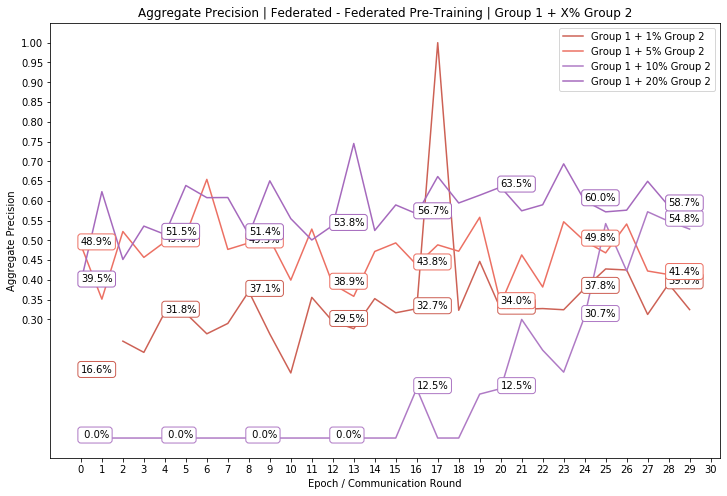

<Figure size 432x288 with 0 Axes>

In [72]:
params.experiment = 'Federated - Federated Pre-Training'
path = cen_no_pre

for metric in metrics:
    params.metric = metric
    make_pain_plot(path, params, "individual", aggregate_cols)

## Prepare plots for Individual metrics

In [ ]:
# Individual plotting
metrics = ['Individual Accuracy', 'Individual Precision', 'Individual Recall', 'Individual F1-Score', 'Individual Avg. Precision']
folder = fed_cen_train
params.experiment = 'Federated - Cen. Pre-Training'
ending = 'individual'
files = os.listdir(folder)
files = [os.path.join(folder, file) for file in files if file.endswith('{}.csv'.format(ending))]
files = sorted(files)

for metric in metrics:
    params.metric = metric
    fig = plt.figure(dpi=300)
    for idx, file in enumerate(files):
        df = pd.read_csv(file, index_col=0)
        df['Person'] = df['Person'].astype(int)
        pivot = df.pivot(index='Epoch', columns='Person', values=params.metric)
        percent = float(file.split('shard-')[1].split('_')[0])
        rounds = 30
        ax = pivot.plot(
            title="{} | {} | Group 1 + {:.0%} Group 2".format(params.metric, params.experiment, percent),
            yticks=np.arange(0.0, 1.05, step=0.05),
            xticks=np.arange(0, rounds+1, step=1),
            figsize=(16,24),
            ax=fig.add_subplot(4, 2, idx+1),
        )
        ax.set_xlabel('Epoch / Communication Round')
        ax.set_ylabel("{}".format(params.metric))
    f_name = time.strftime("%Y-%m-%d-%H%M%S") + r"_{}_{}_{}.png".format(params.dataset, params.experiment, params.metric)
    plt.savefig(os.path.join(FIGURES, f_name), dpi=300)
#     plt.show()

In [11]:
folder = '/Users/nico/PycharmProjects/FederatedLearning/Results/_old/2019-07-30_PAIN_Balanced_Federated/2019-07-30_PAIN_Federated-federated-pre-training'
files = os.listdir(folder)
files = [os.path.join(folder, file) for file in files if file.endswith('{}.csv'.format(''))]
files = sorted(files)

In [23]:
agg_cols = ['Shard', 'Epoch', 'Loss', 'Aggregate Avg. Precision', 'Aggregate Accuracy', 
                  'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']

In [27]:
df_concat = pd.DataFrame(columns=agg_cols)
for file in files:
    df = pd.read_csv(file, index_col=0)
    df['Person'] = df['Person'].astype(int)
    df['Shard'] = file.split('shard-')[1].split('_')[0]
    df = aggregate_df(df, agg_cols)
    df_concat = pd.concat((df_concat, df))

In [36]:
df_concat.reset_index(inplace=True)

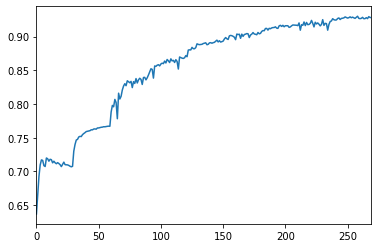

In [37]:
df_concat['Aggregate Accuracy'].plot()

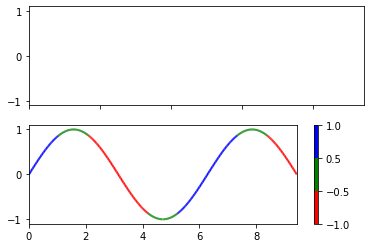

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()

In [40]:
points.shape

(500, 1, 2)